code adapted from https://nn.labml.ai/diffusion/ddpm/unet.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import cv2 as cv
from glob import glob
from sklearn.linear_model import LinearRegression
from torch.utils.data import Dataset, DataLoader
from diffusers.models import UNet2DModel
from diffusers.schedulers import DDIMScheduler
import os
import random
import matplotlib.pyplot as plt

from typing import Optional, Union, List, Tuple


/Users/dak/projects/diffusion-examples/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


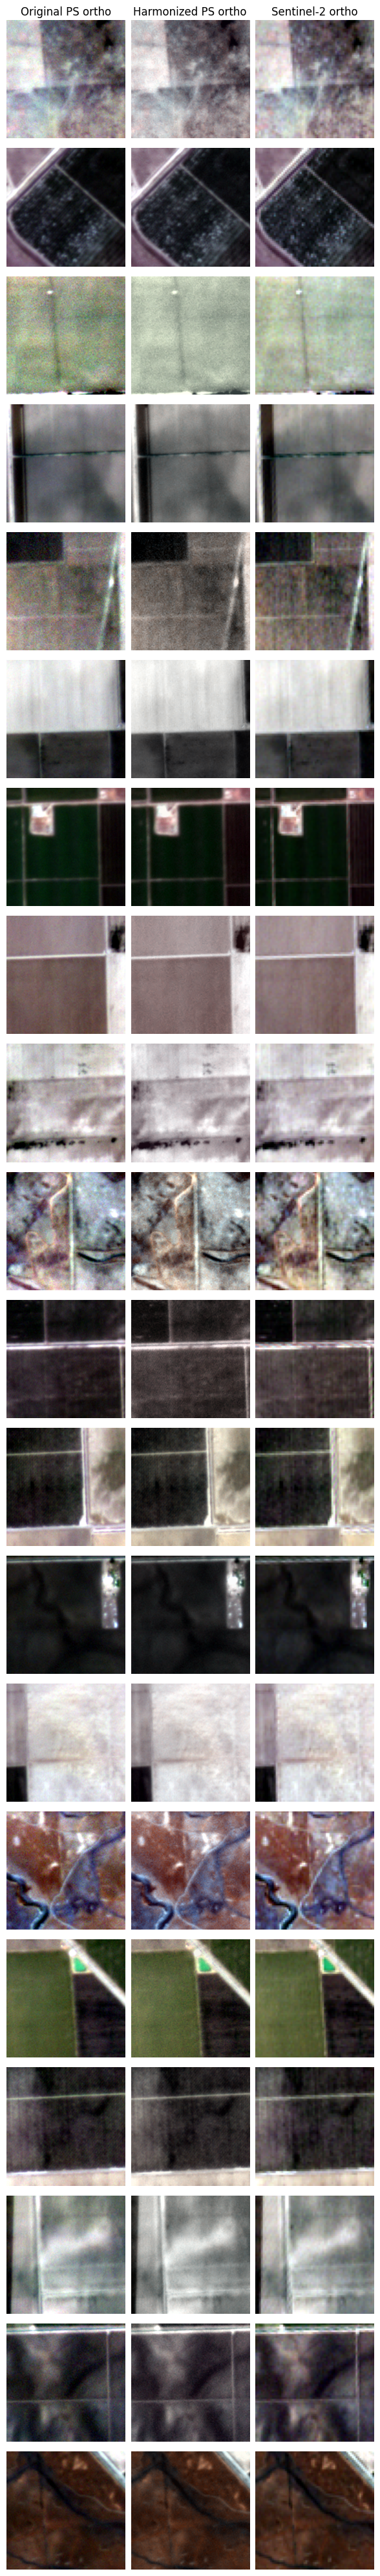

In [2]:
from sklearn.metrics import r2_score

class PlanetDataset(Dataset):
    
    def __init__(self, s2_filepaths: Union[List[str], Tuple[str]], ps_filepaths: Union[List[str], Tuple[str]]):
        super().__init__()
        
        self.s2_filepaths = s2_filepaths
        self.ps_filepaths = ps_filepaths
        
    def __len__(self):
        return len(self.s2_filepaths)
        
    @staticmethod
    def _scale(
        data, 
        in_range: Union[Tuple[int, int], Tuple[float, float]]=(0, 255), 
        out_range: Union[Tuple[int, int], Tuple[float, float]]=(-1.0, 1.0)
    ) -> torch.Tensor:
        
        # scale to 0-1
        data = (data - in_range[0]) / (in_range[1] - in_range[0])
        
        # scale to out_range
        data = data * (out_range[1] - out_range[0]) - out_range[1]
        data = data.clamp(min=out_range[0], max=out_range[1])
        return data
    
    def get_s2_img(self, idx):
        
        s2_img = cv.imread(idx)
        s2_img = cv.cvtColor(s2_img, cv.COLOR_BGR2RGB)
        s2_img = torch.as_tensor(s2_img, dtype=torch.float32)
        s2_img = s2_img.permute(2, 0, 1)
        return self._scale(s2_img)
    
    def get_ps_img(self, idx, harmonize: bool=True, return_s2_img: bool=False):
        
        if return_s2_img and not harmonize:
            raise ValueError('Cannot return Sentinel-2 image when harmonize is set to False')
        
        ps_img = cv.imread(self.ps_filepaths[idx])
        ps_img = cv.cvtColor(ps_img, cv.COLOR_BGR2RGB)
        
        if harmonize:
            
            s2_file = self.ps_filepaths[idx].replace('ps_patch_', 's2_patch_')
            s2_img = cv.imread(s2_file)
            s2_img = cv.cvtColor(s2_img, cv.COLOR_BGR2RGB)
            
            ps_img_downsampled = cv.resize(ps_img, s2_img.shape[:2], interpolation=cv.INTER_LINEAR)
            
            ols = LinearRegression()
            ols.fit(ps_img_downsampled.reshape(-1, 3), s2_img.reshape(-1, 3))
            ps_img_harmonized = ps_img.reshape(-1, 3) @ ols.coef_.T + ols.intercept_
            # print(ols.coef_.T, ols.intercept_)
            ps_img = ps_img_harmonized.reshape(ps_img.shape)

        ps_img = torch.as_tensor(ps_img, dtype=torch.float32)
        ps_img = self._scale(ps_img)
        ps_img = ps_img.permute(2, 0, 1)
        
        if return_s2_img:
            s2_img = torch.as_tensor(s2_img, dtype=torch.float32)
            s2_img = self._scale(s2_img)
            s2_img = s2_img.permute(2, 0, 1)
            return ps_img, s2_img

        else:
            return ps_img
    
    
    def __getitem__(self, idx):
        return self.get_ps_img(idx, harmonize=True, return_s2_img=True)


s2_image_paths = glob('/Volumes/dhester_ssd/dakota_sample_training_sr_images/*/*/s2_patch_*.png')
ps_image_paths = glob('/Volumes/dhester_ssd/dakota_sample_training_sr_images/*/*/ps_patch_*.png')

dataset = PlanetDataset(
    s2_filepaths=s2_image_paths,
    ps_filepaths=ps_image_paths
)

n_idx = 20
fig, ax = plt.subplots(n_idx, 3, figsize=(6, 2*n_idx))

for i in range(n_idx):
    harm_ps_img, s2_img = dataset.get_ps_img(i+10, return_s2_img=True)
    ps_img = dataset.get_ps_img(i+10, harmonize=False)

    ax[i][0].imshow((ps_img.permute(1, 2, 0) + 1) / 2)
    ax[i][1].imshow((harm_ps_img.permute(1, 2, 0) + 1) / 2)
    ax[i][2].imshow((s2_img.permute(1, 2, 0) + 1) / 2)

for axis in ax.ravel():
    axis.axis('off')
    
ax[0][0].set_title('Original PS ortho')
ax[0][1].set_title('Harmonized PS ortho')
ax[0][2].set_title('Sentinel-2 ortho')

fig.tight_layout()

In [3]:
unique_locations = set(path.split(os.sep)[-3] for path in s2_image_paths)
for unique_location in unique_locations:
    print(unique_location, len([path for path in s2_image_paths if path.split(os.sep)[-3] == unique_location]))

val_sites = random.sample(sorted(unique_locations), k=1)
train_sites = [site for site in unique_locations if site not in val_sites]

print(val_sites, train_sites)

15SXS 1770
10SGF 3935
17SKR 4837
13QGB 5712
16TFP 2919
11TQH 6314
18TUL 4053
17MNQ 5438
15TWH 967
13QGF 2490
['16TFP'] ['15SXS', '10SGF', '17SKR', '13QGB', '11TQH', '18TUL', '17MNQ', '15TWH', '13QGF']


In [4]:
train_s2_paths = [fp for fp in s2_image_paths if fp.split(os.sep)[-3] in train_sites]
train_ps_paths = [fp for fp in ps_image_paths if fp.split(os.sep)[-3] in train_sites]
train_dataset = PlanetDataset(train_s2_paths, train_ps_paths)
print(f'Number of samples in training dataset: {len(train_dataset)}')

val_s2_paths = [fp for fp in s2_image_paths if fp.split(os.sep)[-3] in val_sites]
val_ps_paths = [fp for fp in ps_image_paths if fp.split(os.sep)[-3] in val_sites]
val_dataset = PlanetDataset(val_s2_paths, val_ps_paths)
print(f'Number of samples in validation dataset: {len(val_dataset)}')

Number of samples in training dataset: 35516
Number of samples in validation dataset: 2919


In [18]:
model = UNet2DModel(
    sample_size=256,
    in_channels=3,
    out_channels=3,
    block_out_channels=[32, 64, 128, 256],
    down_block_types=["DownBlock2D"] * 4,
    up_block_types=["UpBlock2D"] * 4
)

print(f'Total parameters: {sum([p.numel() for p in model.parameters()])}')

Total parameters: 14158147


In [ ]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f'Using backed {device}')
model.to(device)

batch_size = 1
n_epochs = 3
timesteps = 50

optimizer = torch.optim.AdamW(model.parameters())
scheduler = DDIMScheduler(num_train_timesteps=timesteps)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True)

for epoch in range(n_epochs):
    
    for ps_img, _ in train_dataloader:
        
        X = ps_img.to(device)
        noise = torch.randn(X.shape).to(device)
        timesteps = torch.randint(0, timesteps, (batch_size,)).to(device)
        noisy_X = scheduler.add_noise(X, noise, timesteps)
        noise_pred = model(noisy_X, timesteps).sample
        
        loss = F.mse_loss(noise, noise_pred)
        print(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        

Using backed mps


/Users/dak/projects/diffusion-examples/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 